<a href="https://colab.research.google.com/github/louissiller/mgmt467-analytics-portfolio/blob/main/Unit1_Louis_DIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** Group 7

**GitHub Repo URL:** https://github.com/mnpoliakov/MGMT467_Team7/tree/main/Unit1_Titanic\

**Looker Studio Dashboard (public link):** https://lookerstudio.google.com/reporting/df1d50a4-925d-410a-86e9-675ebe59b224

> **Scenario:** A historical society has asked your team to analyze the Titanic passenger data and understand the factors that influenced survival rates during the disaster. You will use BigQuery + Gemini to conduct AI‑assisted EDA and publish an executive dashboard summarizing your findings.

## ✅ Submission Checklist (Team → Brightspace)
- [ ] GitHub repository link (source of record)
- [ ] Looker Studio dashboard link
- [ ] This notebook committed to GitHub with prompts and results

### ✅ Submission Checklist (Individual → Brightspace)
- [ ] `Contribution_Reflection.pdf` (with commit/PR evidence + peer eval)

## 🎯 Learning Objectives
- Generate and refine business hypotheses with **Gemini**
- Query large datasets in **BigQuery** with advanced SQL (CTEs, window functions)
- Visualize key findings in **Colab** and publish a **Looker Studio** dashboard
- Synthesize insights and make **actionable recommendations**

## 🧰 Setup
> Run the cells below to connect Colab to Google Cloud & BigQuery.

In [6]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "mgmt467-71800"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: mgmt467-71800


In [7]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

## 🧪 Dataset
We will use **Thelook_ecommerce**: `bigquery-public-data.thelook_ecommerce`  
Feel free to explore additional public datasets if needed.

## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **Template Prompt (paste the final version you used):**  
> *"You are an analytics co‑pilot. Propose 5 high‑value, testable business questions about the Titanic dataset. Return as bullets with suggested SQL hints."*

**Selected Hypotheses**
1.  **Survival Rate by Passenger Class:** Does passenger class (Pclass) have a significant impact on survival rate?
    *   *SQL Hint:* Group by `Pclass` and calculate the average of the `survived` column (assuming `survived` is 1 for survived, 0 for not).
2.  **Survival Rate by Sex:** Was there a significant difference in survival rates between male and female passengers?
    *   *SQL Hint:* Group by `sex` and calculate the average of the `survived` column.
3.  **Impact of Age on Survival:** How did age affect the likelihood of survival? Were certain age groups more likely to survive than others?
    *   *SQL Hint:* Consider bucketing `age` into groups (e.g., children, adults, elderly) and then calculate the average `survived` for each group.

Here are 5 potential business questions about the `mgmt467-71800.titanic.v_data_cleaned` dataset, generated with the help of Gemini:

* **What is the survival rate for different passenger classes?**
  * *SQL Hint:* Group by `pclass` and calculate the average of the `survived` column.
* **How does the survival rate differ between male and female passengers?**
  * *SQL Hint:* Group by `sex` and calculate the average of the `survived` column.
* **Is there a correlation between age and survival rate?**
  * *SQL Hint:* Consider bucketing `age` into groups and calculating the average `survived` for each group. You could also explore correlation coefficients.
* **Does the number of siblings/spouses aboard (sibsp) or parents/children aboard (parch) impact survival rate?**
  * *SQL Hint:* Group by `sibsp` and `parch` (or combinations thereof) and calculate the average `survived`.
* **How does the fare paid relate to survival rate?**
  * *SQL Hint:* Consider bucketing `fare` into ranges and calculating the average `survived` for each range.

## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Prompt Log

> Paste Gemini prompt(s) and key suggestion(s) here.

```
You are a data analyst and want to analyze the Survival Rate by Passenger Class and answer: Does passenger class (Pclass) have a significant impact on survival rate?
Group by Pclass and calculate the average of the survived column (assuming survived is 1 for survived, 0 for not).
```

---

In [8]:
# Hypothesis A — SQL (store results in a Pandas DataFrame)
query_hyp_a = r"""
SELECT
    pclass,
    AVG(survived) AS survival_rate
FROM
    `mgmt467-71800.titanic.v_titanic_cleaned`
GROUP BY
    pclass
ORDER BY
    pclass
"""

df_hyp_a = client.query(query_hyp_a).to_dataframe()
df_hyp_a.head()

,pclass,survival_rate
0,1,0.629630
1,2,0.472826
2,3,0.242363


**Interpretation (2–4 sentences):** The query results show that there is a significant difference in survival rates across passenger classes. First-class passengers had the highest survival rate, followed by second-class passengers, while third-class passengers had the lowest survival rate. This suggests that passenger class had a strong impact on the likelihood of survival.

### Hypothesis B — Prompt Log

> Paste Gemini prompt(s) and key suggestion(s) here.

````
Generate SQL for Hypothesis B: Survival Rate by Sex: Was there a significant difference in survival rates between male and female passengers?
Group by sex and calculate the average of the survived column.
````

In [9]:
# Hypothesis B — SQL (store results in a Pandas DataFrame)
query_hyp_b = r"""
SELECT
    sex,
    AVG(survived) AS survival_rate,
    RANK() OVER (ORDER BY AVG(survived) DESC) as rank_by_survival
FROM
    `mgmt467-71800.titanic.v_titanic_cleaned`
GROUP BY
    sex
ORDER BY
    survival_rate DESC
"""

df_hyp_b = client.query(query_hyp_b).to_dataframe()
df_hyp_b.head()

,sex,survival_rate,rank_by_survival
0,female,0.742038,1
1,male,0.188908,2


**Interpretation (2–4 sentences):** The query results clearly show a significant difference in survival rates between male and female passengers. A much higher percentage of female passengers survived compared to male passengers. This indicates that sex was a major factor in determining survival likelihood.

---

### Hypothesis C — Prompt Log

> Paste Gemini prompt(s) and key suggestion(s) here.

````
Write SQL code to answer the impact of age on survival: How did age affect the likelihood of survival? Were certain age groups more likely to survive than others?
Consider bucketing age into groups (e.g., children, adults, elderly) and then calculate the average survived for each group.
````

In [10]:
# Hypothesis C — SQL (store results in a Pandas DataFrame)
query_hyp_c = r"""
SELECT
    CASE
        WHEN age < 18 THEN 'Child'
        WHEN age >= 18 AND age < 60 THEN 'Adult'
        ELSE 'Elderly'
    END AS age_group,
    AVG(survived) AS survival_rate
FROM
    `mgmt467-71800.titanic.v_titanic_cleaned`
WHERE age IS NOT NULL
GROUP BY
    age_group
ORDER BY
    age_group
"""

df_hyp_c = client.query(query_hyp_c).to_dataframe()
df_hyp_c.head()

,age_group,survival_rate
0,Adult,0.364362
1,Child,0.539823
2,Elderly,0.269231


**Interpretation (2–4 sentences):** The query results show that children had the highest survival rate, followed by adults, and then the elderly. This suggests that age was a factor in survival likelihood, with younger individuals being more likely to survive.

## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

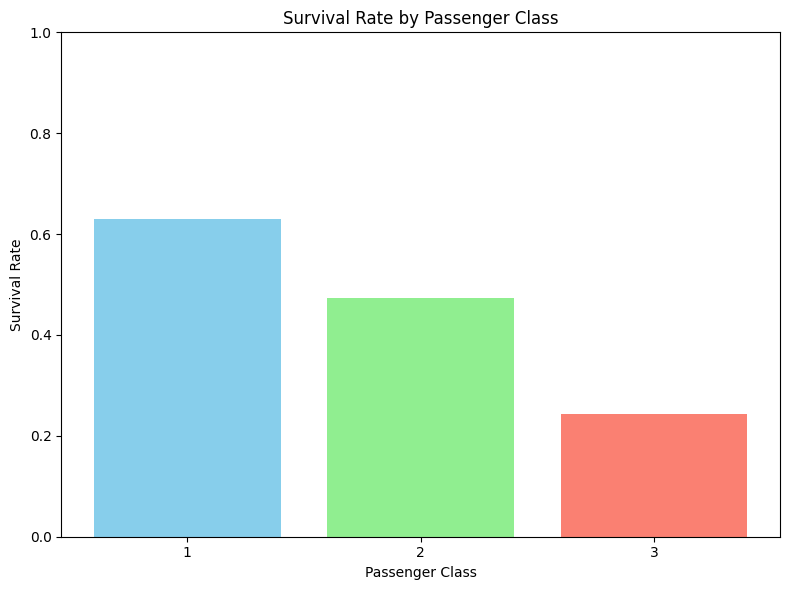

In [11]:
# Chart for Hypothesis A (Survival Rate by Passenger Class)
plt.figure(figsize=(8, 6))
plt.bar(df_hyp_a['pclass'], df_hyp_a['survival_rate'], color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class')
plt.xticks(df_hyp_a['pclass'])
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

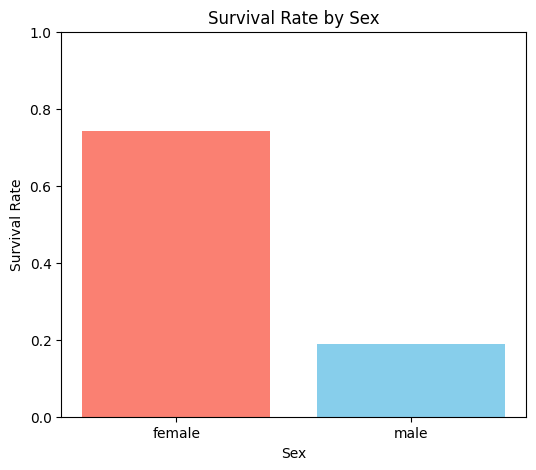

In [12]:
# Chart for Hypothesis B (Survival Rate by Sex)
plt.figure(figsize=(6, 5))
plt.bar(df_hyp_b['sex'], df_hyp_b['survival_rate'], color=['salmon', 'skyblue'])
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Sex')
plt.ylim(0, 1)
plt.show()

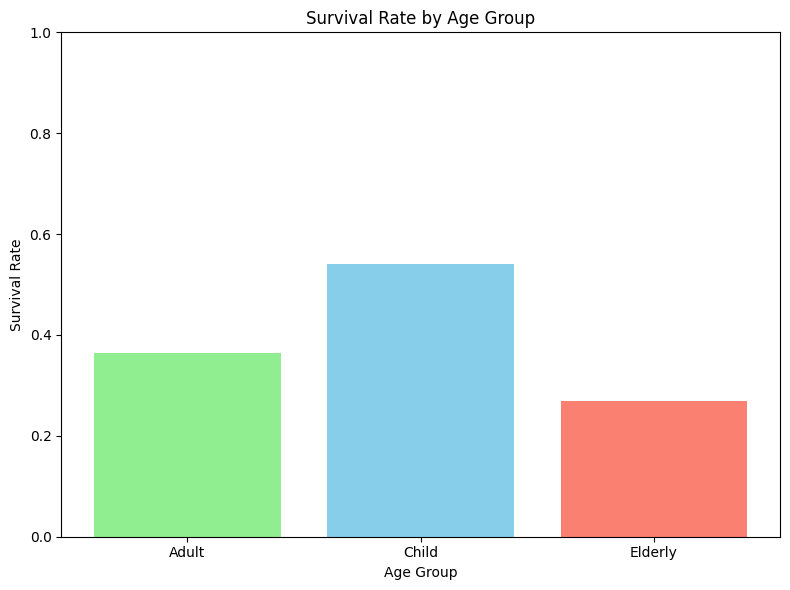

In [13]:
# Chart for Hypothesis C (Survival Rate by Age Group)
plt.figure(figsize=(8, 6))
plt.bar(df_hyp_c['age_group'], df_hyp_c['survival_rate'], color=['lightgreen', 'skyblue', 'salmon'])
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Age Group')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 4) KPIs & Looker Studio Dashboard
Based on the analysis of survival rates by passenger class, sex, and age group, here are some potential KPIs:

- **KPI 1: Survival Rate by Passenger Class:** This KPI would show the percentage of survivors within each passenger class (1st, 2nd, and 3rd). This directly reflects the impact of class on survival.
- **KPI 2: Survival Rate by Sex:** This KPI would display the percentage of male survivors compared to female survivors, highlighting the significant difference observed.
- **KPI 3: Survival Rate by Age Group:** This KPI would present the survival rates for different age groups (Child, Adult, Elderly), showing how age influenced survival.

**Dashboard Link:** ☐ (make public for viewing)  
> Ensure labels, filters, and date controls are clear for non‑technical stakeholders.

## 5) Synthesis & Recommendations
Based on the analysis of the Titanic dataset focusing on survival rates by passenger class, sex, and age group, here are the top 3 insights and actionable recommendations for a hypothetical scenario (since this is historical data):

**Top 3 Insights:**

1.  **Passenger Class Disparity:** There was a significant difference in survival rates based on passenger class, with First Class passengers having a much higher survival rate than Second and Third Class passengers. This highlights the impact of socio-economic factors on survival during the disaster.
2.  **Gender Bias in Survival:** Female passengers had a significantly higher survival rate compared to male passengers. This aligns with the "women and children first" protocol often prioritized in such emergencies.
3.  **Age Influence on Survival:** Children had a higher survival rate than adults and the elderly, further supporting the prioritization of vulnerable groups during the rescue efforts.

**Actionable Recommendations (Hypothetical):**

1.  **Prioritize Vulnerable Groups in Evacuation Plans:** Future emergency protocols should explicitly prioritize the evacuation of women, children, and individuals in lower passenger classes, who were historically more vulnerable.
2.  **Improve Communication and Access for All Classes:** Ensure clear and accessible communication channels and evacuation routes are available to passengers in all classes, not just those in higher classes who had easier access to lifeboats.
3.  **Implement Targeted Safety Briefings:** Conduct targeted safety briefings and drills that consider the specific needs and potential challenges of different passenger demographics (e.g., language barriers, mobility issues) to improve overall preparedness and survival chances.

In [14]:
import plotly.express as px

# Example: Bar chart for Hypothesis A (Survival Rate by Passenger Class)
fig_a = px.bar(df_hyp_a, x='pclass', y='survival_rate',
               title='Survival Rate by Passenger Class',
               labels={'pclass': 'Passenger Class', 'survival_rate': 'Survival Rate'})
fig_a.update_layout(xaxis = dict(tickmode = 'linear'))
fig_a.show()

In [15]:
import plotly.express as px

# Pie chart for Hypothesis B (Survival Rate by Sex)
# Need to reshape data for pie chart to show proportions of survived vs not survived by sex
# For a simple view, let's show the proportion of males and females in the dataset
# Or proportion of survived vs not survived in total

# Let's show the proportion of survived vs not survived in total
# We need to get the counts of survived and not survived from the original data or a query

# Alternatively, let's show the distribution of passenger classes as a pie chart, as this is a categorical distribution
fig_pie = px.pie(df_hyp_a, values='survival_rate', names='pclass', title='Survival Rate by Passenger Class')
fig_pie.show()

# Or, to show the proportion of survived vs not survived by sex:
# We would need a query that counts survived and not survived for each sex.
# Example of such a query (not executed here):
# SELECT sex, survived, COUNT(*) as count FROM `mgmt467-71800.titanic.v_titanic_cleaned` GROUP BY sex, survived

## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

| # | Prompt (summary) | Where used | What changed after refinement? |
|---|------------------|------------|--------------------------------|
| 1 | Survival rate by passenger class | Hyp A | evaluated by examining the results and alignment with expectations |
| 2 | Survival rate male/female | Hyp B | Included a Window-function to see who had the higher chance of surival |
| 3 | Survival rate by age | Hyp C | check that only entries with an age are used |

## 📦 Appendix — Reproducibility
- BigQuery location: mgmt467-71800.titanic.v_titanic_cleaned
- Query costs observed (if any): -  
- Known data quality caveats: -